# Imports

In [14]:
import pandas as pd
import numpy as np
import pickle
import time
from custom_methods.preprocessing import geoid_map

In [15]:
startTime = time.time()

# Geo Data From Avista

In [16]:
# Add in data from GeoData_Anon.csv
geo = pd.read_csv('../../002_Data/Release_4/GeoData_Anon.csv').rename({'spa_prem_id':'SPA_PREM_ID'}, axis=1)

geo = geo.drop(["TRACT_GEOID", "BLOCKGROUP_GEOID_Data"], axis=1).drop_duplicates()

# NOTE: BLOCKGROUP_GEOID and BLOCKGROUP_GEOID_Data contain the same blockgroup number
print(f'Total Records: {len(geo)}')
print(f'Total Premises: {geo.SPA_PREM_ID.nunique()}')
print(f"Contains NaN's: {geo.isnull().any().any()}")
geo.head()

Total Records: 155538
Total Premises: 155538
Contains NaN's: False


,SPA_PREM_ID,BLOCKGROUP_GEOID,POSTAL
0,24381.0,530630112013,99208
1,71746.0,530630024001,99201
2,148291.0,530630024001,99201
3,142249.0,530630105032,99208
4,33506.0,530630106024,99208


# Multi-Family Dwellings

In [17]:
dwellings = pd.read_csv('../../002_Data/Release_4/MultiFamilyDwellingIDs_Anon.csv').rename({'spa_prem_id':'SPA_PREM_ID', 'multi_dwell_id':'MULTI_DWELL_ID'}, axis=1)
dwellings.head()

,SPA_PREM_ID,MULTI_DWELL_ID
0,92052,1
1,52062,1
2,74324,1
3,27282,1
4,21103,1


In [18]:
dwellings.set_index('SPA_PREM_ID', inplace=True)

match_col = 'SPA_PREM_ID'
geo = geo.join(dwellings, how='left', on=match_col)

del dwellings

print(geo.isnull().sum())

SPA_PREM_ID              0
BLOCKGROUP_GEOID         0
POSTAL                   0
MULTI_DWELL_ID      127127
dtype: int64


## Set not multi-dwellings as MULTI_DWELL_ID = -1

In [19]:
geo.MULTI_DWELL_ID.describe()

count    28411.000000
mean      1963.334905
std       1119.264154
min          1.000000
25%        962.000000
50%       2089.000000
75%       2889.000000
max       3768.000000
Name: MULTI_DWELL_ID, dtype: float64

In [20]:
geo.MULTI_DWELL_ID = geo.MULTI_DWELL_ID.replace(to_replace=np.nan, value=-1).astype('int64')
geo.isnull().sum()

SPA_PREM_ID         0
BLOCKGROUP_GEOID    0
POSTAL              0
MULTI_DWELL_ID      0
dtype: int64

# Census Data
https://data.census.gov/cedsci/table?t=Income%20and%20Poverty&g=0500000US53063.150000&y=2015&d=ACS%205-Year%20Estimates%20Detailed%20Tables&tid=ACSDT5Y2015.B19013&hidePreview=false  



In [21]:
match_col = 'BLOCKGROUP_GEOID'

## Aggregate Income
US Census Table: B19025  
NOTE: The Median Income table (B19013) for this year has a lot of missing data, so not using it

In [22]:
# C:\Users\Colin\Documents\SCHOOL_STUFF\EWU\Thesis\002_Data\CensusData\AggIncome\ACSDT5Y2015.B19025_data_with_overlays_2021-04-18T191340.csv
agg_income = pd.read_csv('../../002_Data/CensusData/AggIncome/ACSDT5Y2015.B19025_data_with_overlays_2021-04-18T191340.csv')
print(agg_income.isnull().sum())
agg_income.head()

GEO_ID         0
NAME           0
B19025_001E    1
B19025_001M    1
dtype: int64


,GEO_ID,NAME,B19025_001E,B19025_001M
0,id,Geographic Area Name,Estimate!!Aggregate household income in the pa...,Margin of Error!!Aggregate household income in...
1,1500000US530630002001,"Block Group 1, Census Tract 2, Spokane County,...",11310900,3953586
2,1500000US530630002002,"Block Group 2, Census Tract 2, Spokane County,...",7976900,3043131
3,1500000US530630002003,"Block Group 3, Census Tract 2, Spokane County,...",8076300,4173907
4,1500000US530630002004,"Block Group 4, Census Tract 2, Spokane County,...",23570500,7029237


In [23]:
agg_income.drop(0, axis=0, inplace=True)
newcol = "AGG_INCOME_GEO"
agg_income.rename({"B19025_001E":newcol}, axis=1, inplace=True)

agg_income[match_col] = agg_income["GEO_ID"].map(geoid_map).astype('int64')
agg_income.set_index(match_col, inplace=True)

geo = geo.join(agg_income[newcol], how='left', on=match_col)

del agg_income

print(geo.isnull().sum())
print("\nNumber of unique SPA_PREM_IDs w/NaN "+newcol)
print(geo[geo[newcol].isnull()]["SPA_PREM_ID"].nunique())

SPA_PREM_ID         0
BLOCKGROUP_GEOID    0
POSTAL              0
MULTI_DWELL_ID      0
AGG_INCOME_GEO      0
dtype: int64

Number of unique SPA_PREM_IDs w/NaN AGG_INCOME_GEO
0


## Earnings
US Census Table: B19051

In [24]:
# C:\Users\Colin\Documents\SCHOOL_STUFF\EWU\Thesis\002_Data\CensusData\Earnings\ACSDT5Y2015.B19051_data_with_overlays_2021-04-12T234426.csv
earnings = pd.read_csv('../../002_Data/CensusData/Earnings/ACSDT5Y2015.B19051_data_with_overlays_2021-04-12T234426.csv')
print(earnings.isnull().sum())
earnings.head()

GEO_ID         0
NAME           0
B19051_001E    0
B19051_001M    0
B19051_002E    0
B19051_002M    0
B19051_003E    0
B19051_003M    0
dtype: int64


,GEO_ID,NAME,B19051_001E,B19051_001M,B19051_002E,B19051_002M,B19051_003E,B19051_003M
0,id,Geographic Area Name,Estimate!!Total,Margin of Error!!Total,Estimate!!Total!!With earnings,Margin of Error!!Total!!With earnings,Estimate!!Total!!No earnings,Margin of Error!!Total!!No earnings
1,1500000US530630002001,"Block Group 1, Census Tract 2, Spokane County,...",330,73,255,76,75,34
2,1500000US530630002002,"Block Group 2, Census Tract 2, Spokane County,...",325,94,110,60,215,74
3,1500000US530630002003,"Block Group 3, Census Tract 2, Spokane County,...",270,87,177,83,93,43
4,1500000US530630002004,"Block Group 4, Census Tract 2, Spokane County,...",417,90,351,90,66,34


In [25]:
earnings = earnings.drop(0, axis=0)
newcol = "NO_EARNINGS_GEO"
earnings[newcol] = earnings["B19051_003E"].astype('float') / earnings["B19051_001E"].astype('float')
earnings[match_col] = earnings["GEO_ID"].map(geoid_map).astype("int64")
earnings = earnings.set_index(match_col)

geo = geo.join(earnings[newcol], how='left', on=match_col)
del earnings
print("Nulls:")
print(geo.isnull().sum())
print(f"Ratio > 1: {(geo[newcol] > 1).any()}")
geo.head()

Nulls:
SPA_PREM_ID         0
BLOCKGROUP_GEOID    0
POSTAL              0
MULTI_DWELL_ID      0
AGG_INCOME_GEO      0
NO_EARNINGS_GEO     0
dtype: int64
Ratio > 1: False


,SPA_PREM_ID,BLOCKGROUP_GEOID,POSTAL,MULTI_DWELL_ID,AGG_INCOME_GEO,NO_EARNINGS_GEO
0,24381.0,530630112013,99208,215,44494500,0.256384
1,71746.0,530630024001,99201,-1,23207000,0.474962
2,148291.0,530630024001,99201,484,23207000,0.474962
3,142249.0,530630105032,99208,697,137807700,0.123299
4,33506.0,530630106024,99208,3603,58541800,0.191525


## Poverty
US Census Table B17021

In [26]:
#C:\Users\Colin\Documents\SCHOOL_STUFF\EWU\Thesis\002_Data\CensusData\Poverty\ACSDT5Y2015.B17021_data_with_overlays_2021-04-12T234708.csv
poverty = pd.read_csv('../../002_Data/CensusData/Poverty/ACSDT5Y2015.B17021_data_with_overlays_2021-04-12T234708.csv')
print(poverty.isnull().any().any())
poverty.head()

False


,GEO_ID,NAME,B17021_001E,B17021_001M,B17021_002E,B17021_002M,B17021_003E,B17021_003M,B17021_004E,B17021_004M,...,B17021_031E,B17021_031M,B17021_032E,B17021_032M,B17021_033E,B17021_033M,B17021_034E,B17021_034M,B17021_035E,B17021_035M
0,id,Geographic Area Name,Estimate!!Total,Margin of Error!!Total,Estimate!!Total!!Income in the past 12 months ...,Margin of Error!!Total!!Income in the past 12 ...,Estimate!!Total!!Income in the past 12 months ...,Margin of Error!!Total!!Income in the past 12 ...,Estimate!!Total!!Income in the past 12 months ...,Margin of Error!!Total!!Income in the past 12 ...,...,Estimate!!Total!!Income in the past 12 months ...,Margin of Error!!Total!!Income in the past 12 ...,Estimate!!Total!!Income in the past 12 months ...,Margin of Error!!Total!!Income in the past 12 ...,Estimate!!Total!!Income in the past 12 months ...,Margin of Error!!Total!!Income in the past 12 ...,Estimate!!Total!!Income in the past 12 months ...,Margin of Error!!Total!!Income in the past 12 ...,Estimate!!Total!!Income in the past 12 months ...,Margin of Error!!Total!!Income in the past 12 ...
1,1500000US530630002001,"Block Group 1, Census Tract 2, Spokane County,...",928,257,475,229,429,230,140,205,...,72,50,72,50,72,50,0,12,0,12
2,1500000US530630002002,"Block Group 2, Census Tract 2, Spokane County,...",566,211,290,160,194,143,65,76,...,137,68,116,57,116,57,0,12,21,33
3,1500000US530630002003,"Block Group 3, Census Tract 2, Spokane County,...",582,186,197,96,74,49,19,31,...,164,151,89,80,23,38,66,70,75,77
4,1500000US530630002004,"Block Group 4, Census Tract 2, Spokane County,...",1035,325,198,142,161,142,0,12,...,205,137,143,73,111,69,32,41,62,90


In [27]:
poverty.drop(0, axis=0, inplace=True)
newcol = "BELOW_POVERTY_LVL_GEO"
poverty[newcol] = poverty["B17021_002E"].astype('float') / poverty["B17021_001E"].astype('float')
poverty[match_col] = poverty["GEO_ID"].map(geoid_map).astype('int64')
poverty = poverty.set_index(match_col)

geo = geo.join(poverty[newcol], how='left', on=match_col)
del poverty
print("Nulls:")
print(geo.isnull().sum())
print(f"Ratio > 1: {(geo[newcol] > 1).any()}")
geo.head()

Nulls:
SPA_PREM_ID              0
BLOCKGROUP_GEOID         0
POSTAL                   0
MULTI_DWELL_ID           0
AGG_INCOME_GEO           0
NO_EARNINGS_GEO          0
BELOW_POVERTY_LVL_GEO    0
dtype: int64
Ratio > 1: False


,SPA_PREM_ID,BLOCKGROUP_GEOID,POSTAL,MULTI_DWELL_ID,AGG_INCOME_GEO,NO_EARNINGS_GEO,BELOW_POVERTY_LVL_GEO
0,24381.0,530630112013,99208,215,44494500,0.256384,0.081163
1,71746.0,530630024001,99201,-1,23207000,0.474962,0.565543
2,148291.0,530630024001,99201,484,23207000,0.474962,0.565543
3,142249.0,530630105032,99208,697,137807700,0.123299,0.001921
4,33506.0,530630106024,99208,3603,58541800,0.191525,0.019392


## Food Stamps / SNAP
US Census Table: B22010

In [28]:
# C:\Users\Colin\Documents\SCHOOL_STUFF\EWU\Thesis\002_Data\CensusData\FoodStamps\ACSDT5Y2015.B22010_data_with_overlays_2021-04-18T182516.csv
snap = pd.read_csv('../../002_Data/CensusData/FoodStamps/ACSDT5Y2015.B22010_data_with_overlays_2021-04-18T182516.csv')
print(snap.isnull().any().any())
snap.head()

False


,GEO_ID,NAME,B22010_001E,B22010_001M,B22010_002E,B22010_002M,B22010_003E,B22010_003M,B22010_004E,B22010_004M,B22010_005E,B22010_005M,B22010_006E,B22010_006M,B22010_007E,B22010_007M
0,id,Geographic Area Name,Estimate!!Total,Margin of Error!!Total,Estimate!!Total!!Household received Food Stamp...,Margin of Error!!Total!!Household received Foo...,Estimate!!Total!!Household received Food Stamp...,Margin of Error!!Total!!Household received Foo...,Estimate!!Total!!Household received Food Stamp...,Margin of Error!!Total!!Household received Foo...,Estimate!!Total!!Household did not receive Foo...,Margin of Error!!Total!!Household did not rece...,Estimate!!Total!!Household did not receive Foo...,Margin of Error!!Total!!Household did not rece...,Estimate!!Total!!Household did not receive Foo...,Margin of Error!!Total!!Household did not rece...
1,1500000US530630002001,"Block Group 1, Census Tract 2, Spokane County,...",330,73,154,57,57,37,97,54,176,67,74,48,102,51
2,1500000US530630002002,"Block Group 2, Census Tract 2, Spokane County,...",325,94,224,92,130,66,94,74,101,39,44,26,57,32
3,1500000US530630002003,"Block Group 3, Census Tract 2, Spokane County,...",270,87,148,75,76,52,72,65,122,69,16,19,106,67
4,1500000US530630002004,"Block Group 4, Census Tract 2, Spokane County,...",417,90,157,79,35,44,122,73,260,77,67,52,193,63


In [29]:
snap.drop(0, axis=0, inplace=True)
newcol = "SNAP_GEO"
snap[newcol] = snap["B22010_002E"].astype('float') / snap["B22010_001E"].astype('float')
snap[match_col] = snap["GEO_ID"].map(geoid_map).astype('int64')
snap = snap.set_index(match_col)

geo = geo.join(snap[newcol], how='left', on=match_col)
del snap
print("Nulls:")
print(geo.isnull().sum())
print(f"Ratio > 1: {(geo[newcol] > 1).any()}")
geo.head()

Nulls:
SPA_PREM_ID              0
BLOCKGROUP_GEOID         0
POSTAL                   0
MULTI_DWELL_ID           0
AGG_INCOME_GEO           0
NO_EARNINGS_GEO          0
BELOW_POVERTY_LVL_GEO    0
SNAP_GEO                 0
dtype: int64
Ratio > 1: False


,SPA_PREM_ID,BLOCKGROUP_GEOID,POSTAL,MULTI_DWELL_ID,AGG_INCOME_GEO,NO_EARNINGS_GEO,BELOW_POVERTY_LVL_GEO,SNAP_GEO
0,24381.0,530630112013,99208,215,44494500,0.256384,0.081163,0.119510
1,71746.0,530630024001,99201,-1,23207000,0.474962,0.565543,0.432473
2,148291.0,530630024001,99201,484,23207000,0.474962,0.565543,0.432473
3,142249.0,530630105032,99208,697,137807700,0.123299,0.001921,0.009608
4,33506.0,530630106024,99208,3603,58541800,0.191525,0.019392,0.091525


## Education Attainment
US Census Table: B15003

In [30]:
# C:\Users\Colin\Documents\SCHOOL_STUFF\EWU\Thesis\002_Data\CensusData\Education\ACSDT5Y2015.B15003_data_with_overlays_2021-04-18T184101.csv
edu = pd.read_csv('../../002_Data/CensusData/Education/ACSDT5Y2015.B15003_data_with_overlays_2021-04-18T184101.csv')
print(edu.isnull().any().any())
edu.head()

False


,GEO_ID,NAME,B15003_001E,B15003_001M,B15003_002E,B15003_002M,B15003_003E,B15003_003M,B15003_004E,B15003_004M,...,B15003_021E,B15003_021M,B15003_022E,B15003_022M,B15003_023E,B15003_023M,B15003_024E,B15003_024M,B15003_025E,B15003_025M
0,id,Geographic Area Name,Estimate!!Total,Margin of Error!!Total,Estimate!!Total!!No schooling completed,Margin of Error!!Total!!No schooling completed,Estimate!!Total!!Nursery school,Margin of Error!!Total!!Nursery school,Estimate!!Total!!Kindergarten,Margin of Error!!Total!!Kindergarten,...,Estimate!!Total!!Associate's degree,Margin of Error!!Total!!Associate's degree,Estimate!!Total!!Bachelor's degree,Margin of Error!!Total!!Bachelor's degree,Estimate!!Total!!Master's degree,Margin of Error!!Total!!Master's degree,Estimate!!Total!!Professional school degree,Margin of Error!!Total!!Professional school de...,Estimate!!Total!!Doctorate degree,Margin of Error!!Total!!Doctorate degree
1,1500000US530630002001,"Block Group 1, Census Tract 2, Spokane County,...",472,122,18,26,0,12,0,12,...,97,59,29,33,54,48,8,13,0,12
2,1500000US530630002002,"Block Group 2, Census Tract 2, Spokane County,...",450,144,0,12,0,12,0,12,...,25,22,62,55,22,21,0,12,0,12
3,1500000US530630002003,"Block Group 3, Census Tract 2, Spokane County,...",408,152,0,12,13,20,0,12,...,82,54,18,20,0,12,0,12,0,12
4,1500000US530630002004,"Block Group 4, Census Tract 2, Spokane County,...",814,242,19,24,0,12,0,12,...,45,29,62,50,21,18,0,12,0,12


In [31]:
# Get rid of margin of error columns
for col in edu.columns:
    if "Margin of Error" in edu.loc[0,col]:
        edu = edu.drop(col, axis=1)

# Find GED column index
edu.iloc[0,19]

'Estimate!!Total!!GED or alternative credential'

In [32]:
edu.iloc[0].to_list()

['id',
 'Geographic Area Name',
 'Estimate!!Total',
 'Estimate!!Total!!No schooling completed',
 'Estimate!!Total!!Nursery school',
 'Estimate!!Total!!Kindergarten',
 'Estimate!!Total!!1st grade',
 'Estimate!!Total!!2nd grade',
 'Estimate!!Total!!3rd grade',
 'Estimate!!Total!!4th grade',
 'Estimate!!Total!!5th grade',
 'Estimate!!Total!!6th grade',
 'Estimate!!Total!!7th grade',
 'Estimate!!Total!!8th grade',
 'Estimate!!Total!!9th grade',
 'Estimate!!Total!!10th grade',
 'Estimate!!Total!!11th grade',
 'Estimate!!Total!!12th grade, no diploma',
 'Estimate!!Total!!Regular high school diploma',
 'Estimate!!Total!!GED or alternative credential',
 'Estimate!!Total!!Some college, less than 1 year',
 'Estimate!!Total!!Some college, 1 or more years, no degree',
 "Estimate!!Total!!Associate's degree",
 "Estimate!!Total!!Bachelor's degree",
 "Estimate!!Total!!Master's degree",
 'Estimate!!Total!!Professional school degree',
 'Estimate!!Total!!Doctorate degree']

In [33]:
cutoff = 13
edu.iloc[0, cutoff:].to_list()

['Estimate!!Total!!8th grade',
 'Estimate!!Total!!9th grade',
 'Estimate!!Total!!10th grade',
 'Estimate!!Total!!11th grade',
 'Estimate!!Total!!12th grade, no diploma',
 'Estimate!!Total!!Regular high school diploma',
 'Estimate!!Total!!GED or alternative credential',
 'Estimate!!Total!!Some college, less than 1 year',
 'Estimate!!Total!!Some college, 1 or more years, no degree',
 "Estimate!!Total!!Associate's degree",
 "Estimate!!Total!!Bachelor's degree",
 "Estimate!!Total!!Master's degree",
 'Estimate!!Total!!Professional school degree',
 'Estimate!!Total!!Doctorate degree']

<AxesSubplot:>

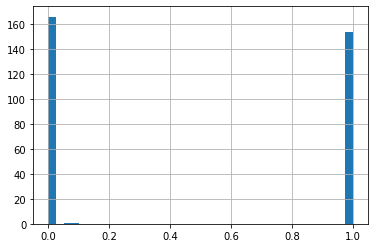

In [34]:
edu.drop(0, axis=0, inplace=True)
newcol = "ABOVE_GRD7_GEO"

# Sum of people above Grade 7 / total
edu[newcol] = edu.iloc[:,cutoff:].sum(axis=1) / edu.iloc[:,3:].sum(axis=1)
edu[newcol].hist(bins=40)

In [35]:
edu[match_col] = edu["GEO_ID"].map(geoid_map).astype('int64')
edu = edu.set_index(match_col)

geo = geo.join(edu[newcol], how='left', on=match_col)
del edu
print("Nulls:")
print(geo.isnull().sum())
print(f"Ratio > 1: {(geo[newcol] > 1).any()}")
geo.head()

Nulls:
SPA_PREM_ID              0
BLOCKGROUP_GEOID         0
POSTAL                   0
MULTI_DWELL_ID           0
AGG_INCOME_GEO           0
NO_EARNINGS_GEO          0
BELOW_POVERTY_LVL_GEO    0
SNAP_GEO                 0
ABOVE_GRD7_GEO           0
dtype: int64
Ratio > 1: False


,SPA_PREM_ID,BLOCKGROUP_GEOID,POSTAL,MULTI_DWELL_ID,AGG_INCOME_GEO,NO_EARNINGS_GEO,BELOW_POVERTY_LVL_GEO,SNAP_GEO,ABOVE_GRD7_GEO
0,24381.0,530630112013,99208,215,44494500,0.256384,0.081163,0.119510,2.499965e-05
1,71746.0,530630024001,99201,-1,23207000,0.474962,0.565543,0.432473,2.692175e-12
2,148291.0,530630024001,99201,484,23207000,0.474962,0.565543,0.432473,2.692175e-12
3,142249.0,530630105032,99208,697,137807700,0.123299,0.001921,0.009608,1.000000e+00
4,33506.0,530630106024,99208,3603,58541800,0.191525,0.019392,0.091525,1.000000e+00


## Public Assistance
US Census Table: B19057

In [36]:
# C:\Users\Colin\Documents\SCHOOL_STUFF\EWU\Thesis\002_Data\CensusData\PublicAssistance\ACSDT5Y2015.B19057_data_with_overlays_2021-04-18T190814.csv
assist = pd.read_csv('../../002_Data/CensusData/PublicAssistance/ACSDT5Y2015.B19057_data_with_overlays_2021-04-18T190814.csv')
print(assist.isnull().any().any())
assist.head()

False


,GEO_ID,NAME,B19057_001E,B19057_001M,B19057_002E,B19057_002M,B19057_003E,B19057_003M
0,id,Geographic Area Name,Estimate!!Total,Margin of Error!!Total,Estimate!!Total!!With public assistance income,Margin of Error!!Total!!With public assistance...,Estimate!!Total!!No public assistance income,Margin of Error!!Total!!No public assistance i...
1,1500000US530630002001,"Block Group 1, Census Tract 2, Spokane County,...",330,73,16,13,314,75
2,1500000US530630002002,"Block Group 2, Census Tract 2, Spokane County,...",325,94,55,47,270,90
3,1500000US530630002003,"Block Group 3, Census Tract 2, Spokane County,...",270,87,15,17,255,87
4,1500000US530630002004,"Block Group 4, Census Tract 2, Spokane County,...",417,90,82,66,335,82


In [37]:
assist.drop(0, axis=0, inplace=True)
newcol = "PUBLIC_ASSIST_GEO"

assist[newcol] = assist["B19057_002E"].astype('float') / assist["B19057_001E"].astype('float')
assist[match_col] = assist["GEO_ID"].map(geoid_map).astype('int64')
assist = assist.set_index(match_col)

geo = geo.join(assist[newcol], how='left', on=match_col)
del assist
print("Nulls:")
print(geo.isnull().sum())
print(f"Ratio > 1: {(geo[newcol] > 1).any()}")
geo.head()

Nulls:
SPA_PREM_ID              0
BLOCKGROUP_GEOID         0
POSTAL                   0
MULTI_DWELL_ID           0
AGG_INCOME_GEO           0
NO_EARNINGS_GEO          0
BELOW_POVERTY_LVL_GEO    0
SNAP_GEO                 0
ABOVE_GRD7_GEO           0
PUBLIC_ASSIST_GEO        0
dtype: int64
Ratio > 1: False


,SPA_PREM_ID,BLOCKGROUP_GEOID,POSTAL,MULTI_DWELL_ID,AGG_INCOME_GEO,NO_EARNINGS_GEO,BELOW_POVERTY_LVL_GEO,SNAP_GEO,ABOVE_GRD7_GEO,PUBLIC_ASSIST_GEO
0,24381.0,530630112013,99208,215,44494500,0.256384,0.081163,0.119510,2.499965e-05,0.015322
1,71746.0,530630024001,99201,-1,23207000,0.474962,0.565543,0.432473,2.692175e-12,0.157815
2,148291.0,530630024001,99201,484,23207000,0.474962,0.565543,0.432473,2.692175e-12,0.157815
3,142249.0,530630105032,99208,697,137807700,0.123299,0.001921,0.009608,1.000000e+00,0.009608
4,33506.0,530630106024,99208,3603,58541800,0.191525,0.019392,0.091525,1.000000e+00,0.091525


# Save

In [38]:
geo.head()

,SPA_PREM_ID,BLOCKGROUP_GEOID,POSTAL,MULTI_DWELL_ID,AGG_INCOME_GEO,NO_EARNINGS_GEO,BELOW_POVERTY_LVL_GEO,SNAP_GEO,ABOVE_GRD7_GEO,PUBLIC_ASSIST_GEO
0,24381.0,530630112013,99208,215,44494500,0.256384,0.081163,0.119510,2.499965e-05,0.015322
1,71746.0,530630024001,99201,-1,23207000,0.474962,0.565543,0.432473,2.692175e-12,0.157815
2,148291.0,530630024001,99201,484,23207000,0.474962,0.565543,0.432473,2.692175e-12,0.157815
3,142249.0,530630105032,99208,697,137807700,0.123299,0.001921,0.009608,1.000000e+00,0.009608
4,33506.0,530630106024,99208,3603,58541800,0.191525,0.019392,0.091525,1.000000e+00,0.091525


In [39]:
geo.isnull().sum()

SPA_PREM_ID              0
BLOCKGROUP_GEOID         0
POSTAL                   0
MULTI_DWELL_ID           0
AGG_INCOME_GEO           0
NO_EARNINGS_GEO          0
BELOW_POVERTY_LVL_GEO    0
SNAP_GEO                 0
ABOVE_GRD7_GEO           0
PUBLIC_ASSIST_GEO        0
dtype: int64

In [40]:
filename = '../../002_Data/Release_4/processed_geo.pickle'
outfile = open(filename, 'wb')
pickle.dump(geo, outfile)
outfile.close()

# Time

In [41]:
from custom_methods.calc_time import calc_time_from_sec

calc_time_from_sec(time.time()-startTime)

hours:minutes:seconds = 0:0:3.856233596801758
